<a href="https://colab.research.google.com/github/gongboogi/SchoolWork/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EA%B0%90%EC%A0%95%ED%91%9C%ED%98%843_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

## Data



In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir data_copy

In [ ]:
!unzip /content/drive/MyDrive/data/"7_Facial Expression".zip -d /content/data_copy

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
         continuing with "central" filename version
  inflating: /content/data_copy/중립/0d18ae1ed7d9e912864b736523a94a24db0595bf273964cb532e62a6087cf325_여_30_중립_상업시설&점포&시장_20201207000523-003-008.jpg  
중립/0d18ae1ed7d9e912864b736523a94a24db0595bf273964cb532e62a6087cf325_여_30_중립_상업시설&점포&시장_20201207000523-003-011.jpg:  mismatching "local" filename (ьдСыж╜/0d18ae1ed7d9e912864b736523a94a24db0595bf273964cb532e62a6087cf325_ьЧм_30_ьдСыж╜_ьГБьЧЕьЛЬьДд&ьаРэПм&ьЛЬьЮе_20201207000523-003-011.jpg),
         continuing with "central" filename version
  inflating: /content/data_copy/중립/0d18ae1ed7d9e912864b736523a94a24db0595bf273964cb532e62a6087cf325_여_30_중립_상업시설&점포&시장_20201207000523-003-011.jpg  
중립/0d18ae1ed7d9e912864b736523a94a24db0595bf273964cb532e62a6087cf325_여_30_중립_숙박 및 거주공간_20201207000605-010-001.jpg:  mismatching "local" filename (ьдСыж╜/0d18ae1ed7d9e912864b736523a94a24db0595bf273964cb532e62a6087cf325_ьЧм_30_ьдСыж╜_ьИЩы░Х ы░П ъ▒░ьг╝ъ│╡ъ░Д_20201207000605-010-00

In [ ]:
dir_ = Path('/content/data_copy')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/data_copy/중립/0d18ae1ed7d9e912864b7365...,중립
1,/content/data_copy/기쁨/01a6c69e76d729863380b839...,기쁨
2,/content/data_copy/분노/01a6c69e76d729863380b839...,분노
3,/content/data_copy/분노/0b33836b914f544c31e3a642...,분노
4,/content/data_copy/기쁨/0d18ae1ed7d9e912864b7365...,기쁨


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 2090

Number of different labels: 7

Labels: ['중립' '기쁨' '분노' '상처' '슬픔' '불안' '당황']


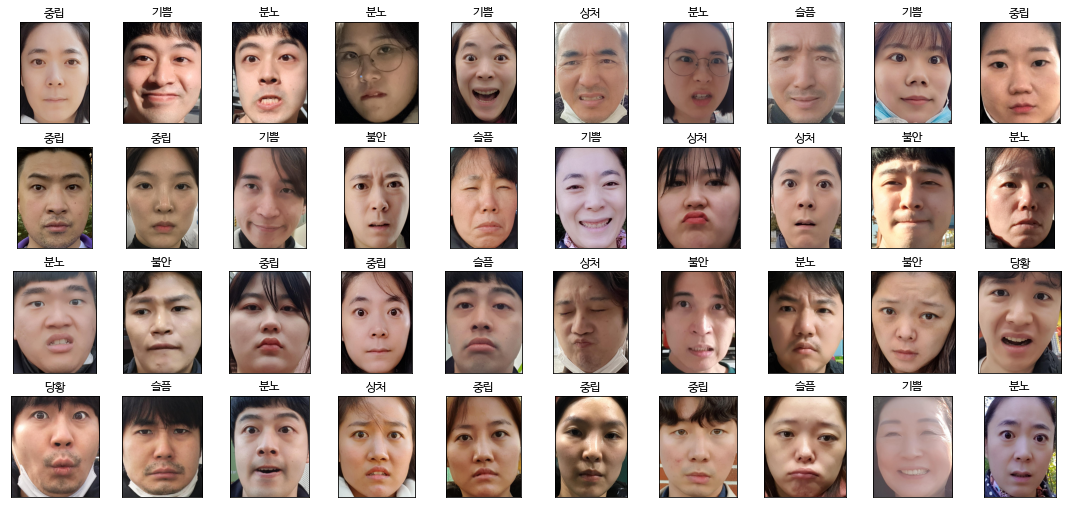

In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# Label Category 분포 확인

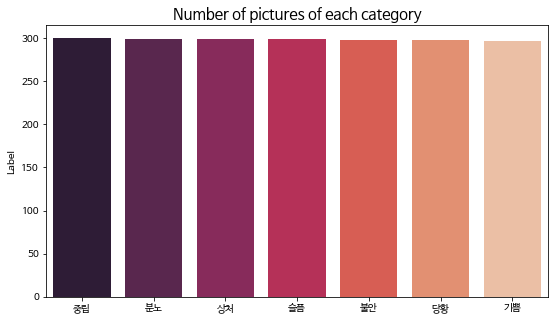

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

## 이미지 데이터 Train, Test 데이터로 분류

In [ ]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((1881, 2), (209, 2))

## 베이스 라인 모델

### 모델 전처리

In [ ]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.1)

train_gen = train_datagen.flow_from_directory('/content/data_copy',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')

val_gen  = train_datagen.flow_from_directory('/content/data_copy',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 1890 images belonging to 7 classes.
Found 210 images belonging to 7 classes.


## 딥러닝 CNN모델로 베이스라인 모델링

In [ ]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=7, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [ ]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
60/60 [==============================] - 81s 1s/step - loss: 1.9524 - accuracy: 0.2048 - val_loss: 1.9354 - val_accuracy: 0.2048
Epoch 2/10
60/60 [==============================] - 79s 1s/step - loss: 1.7210 - accuracy: 0.3365 - val_loss: 1.8742 - val_accuracy: 0.2429
Epoch 3/10
60/60 [==============================] - 76s 1s/step - loss: 1.4274 - accuracy: 0.4709 - val_loss: 2.0532 - val_accuracy: 0.2333
Epoch 4/10
60/60 [==============================] - 78s 1s/step - loss: 1.0660 - accuracy: 0.6079 - val_loss: 2.3187 - val_accuracy: 0.2048
Epoch 5/10
60/60 [==============================] - 79s 1s/step - loss: 0.6987 - accuracy: 0.7624 - val_loss: 2.9049 - val_accuracy: 0.2571
Epoch 6/10
60/60 [==============================] - 76s 1s/step - loss: 0.4282 - accuracy: 0.8593 - val_loss: 3.2350 - val_accuracy: 0.2476
Epoch 7/10
60/60 [==============================] - 78s 1s/step - loss: 0.1880 - accuracy: 0.9545 - val_loss: 4.2305 - val_accuracy: 0.2524
Epoch 8/10
60/60 [==